# __Springboard Data Science Capstone 3 Project__
# _Predicting the Price of Energy_

### Pre-Processing & Modeling

##### _Ben Takacs_
###### __Python version 3.10.4__

### __Imports and File Location__

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime
from functions import load_csv_data, arima_mse, model_eval, sarima_mse

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,  mean_squared_error, root_mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose


### __Load Data__

In [3]:
df = pd.read_csv('./data/df1.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df

,"Average Price of Electricity to Ultimate Customers, Residential",Total Renewable Energy Consumption,Total Petroleum Consumed by the Residential Sector,Natural Gas Consumed by the Electric Power Sector,"Natural Gas Consumed by the Transportation Sector, Vehicle Fuel"
Month,,,,,
1990-02-01,7.48,0.321465,143.972,153.181,0.021
1990-03-01,7.57,0.353956,129.117,214.167,0.023
1990-04-01,7.69,0.334136,108.024,231.641,0.022
1990-05-01,7.96,0.317791,94.930,283.776,0.023
1990-06-01,8.10,0.289276,87.671,345.768,0.022
...,...,...,...,...,...
2024-05-01,16.43,0.758321,53.691,1045.631,4.514
2024-06-01,16.42,0.742351,40.900,1243.853,4.368
2024-07-01,16.63,0.733689,31.619,1534.444,4.514


Average price is in units of cents per kilowatt hour, including taxes.\
Renewable energy consumption is in units of quadrillion Btu (10^15)\
Petroleum consumption is in units of trillion Btu (10^12)\
Natural gas consumed is in units of billion cubic feet (10^12)\
Need to convert  energies to same unit.
Also going to rename columsn to something easier.

In [4]:
df.rename(columns={'Average Price of Electricity to Ultimate Customers, Residential':'Price', 'Total Renewable Energy Consumption':'Renewable', 'Total Petroleum Consumed by the Residential Sector':'Petroleum', 'Natural Gas Consumed by the Electric Power Sector':'Electric', 'Natural Gas Consumed by the Transportation Sector, Vehicle Fuel':'Transportation'}, inplace=True)
df.Renewable *= 1e3
df

,Price,Renewable,Petroleum,Electric,Transportation
Month,,,,,
1990-02-01,7.48,321.465,143.972,153.181,0.021
1990-03-01,7.57,353.956,129.117,214.167,0.023
1990-04-01,7.69,334.136,108.024,231.641,0.022
1990-05-01,7.96,317.791,94.930,283.776,0.023
1990-06-01,8.10,289.276,87.671,345.768,0.022
...,...,...,...,...,...
2024-05-01,16.43,758.321,53.691,1045.631,4.514
2024-06-01,16.42,742.351,40.900,1243.853,4.368
2024-07-01,16.63,733.689,31.619,1534.444,4.514


Renewable and Petroleum now have same units (trillion Btu)

In [5]:
exog = pd.read_csv('./data/exog.csv', index_col=0)
exog.set_index(pd.to_datetime(exog.index), inplace=True)
exog

,Population,GDP
Month,,
1990-02-01,252.273689,10058.925806
1990-03-01,252.500884,10087.247931
1990-04-01,252.728323,10115.630336
1990-05-01,252.956003,10144.072517
1990-06-01,253.183924,10172.573960
...,...,...
2024-05-01,335.258213,23340.273105
2024-06-01,335.309775,23404.211001
2024-07-01,335.359756,23468.810867


##### Don't need to scale data because it's a time series

### __Test Train Split__

In [6]:
# Make differenced dataframe as well for use with modeling
df_diff = pd.DataFrame()
for col in df.columns:
    df_diff[col] = np.diff(df[col])

df_diff.index = df.index[:-1]
df_diff.dropna(inplace=True)
df_diff

,Price,Renewable,Petroleum,Electric,Transportation
Month,,,,,
1990-02-01,0.09,32.491,-14.855,60.986,0.002
1990-03-01,0.12,-19.820,-21.093,17.474,-0.001
1990-04-01,0.27,-16.345,-13.094,52.135,0.001
1990-05-01,0.14,-28.515,-7.259,61.992,-0.001
1990-06-01,0.08,26.596,-2.301,33.816,0.001
...,...,...,...,...,...
2024-04-01,-0.45,21.792,-17.515,163.693,0.146
2024-05-01,-0.01,-15.970,-12.791,198.222,-0.146
2024-06-01,0.21,-8.662,-9.281,290.591,0.146


In [7]:
split = 0.7
splitdate = datetime.date(df.index[int(len(df)*0.7)].year, df.index[int(len(df)*0.7)].month,1)
splitdateahead = datetime.date(splitdate.year, splitdate.month+1,1)
splitdateback = datetime.date(splitdate.year, splitdate.month-1,1)

print(splitdate)
#Endogenous vars
# normal
train, test = train_test_split(df, train_size=split, shuffle=False)
ytrain = train.Price; ytest = test.Price
xtrain = train.drop(columns='Price'); xtest = test.drop(columns='Price')

# differenced
train_diff, test_diff = train_test_split(df_diff, train_size=split, shuffle=False)
ytrain_diff = train_diff.Price; ytest_diff = test_diff.Price
xtrain_diff = train_diff.drop(columns='Price')
xtest_diff = test_diff.drop(columns='Price')

# Exogenous vars
extrain, extest = train_test_split(exog, train_size=split, shuffle=False)

2014-05-01


In [8]:
print(train.shape, test.shape)
print(extrain.shape, extest.shape)
print(train_diff.shape, test_diff.shape)

(291, 5) (125, 5)
(291, 2) (125, 2)
(290, 5) (125, 5)


### __ARIMA Modeling__

Only takes one variable, price. 

### Eyeball Analysis

From our ACF and PACF analysis in the EDA section, we guessed a good model would be ARIMA of order (1,1,1) or (1,1,2).

In [9]:
model_price_1 = ARIMA(ytrain_diff, order=(1,1,1))
model_price_1_fit = model_price_1.fit()
print(model_price_1_fit.summary())

model_price_2 = ARIMA(ytrain_diff, order=(1,1,2))
model_price_2_fit = model_price_2.fit()
print(model_price_2_fit.summary())

aic_delta = model_price_2_fit.aic - model_price_1_fit.aic
print(aic_delta)

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  290
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  40.933
Date:                Sun, 16 Mar 2025   AIC                            -75.867
Time:                        13:21:12   BIC                            -64.868
Sample:                    02-01-1990   HQIC                           -71.459
                         - 03-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2929      0.241     -1.216      0.224      -0.765       0.179
ma.L1          0.0687      0.256      0.268      0.789      -0.434       0.571
sigma2         0.0441      0.003     13.620      0.0

/Users/bencetakacs/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/bencetakacs/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/bencetakacs/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/bencetakacs/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/bencetakacs/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/base/tsa_mod

Model of order (1,1,1) has lower AIC.

### Now we can search a range of orders to find the best fit (here lowest AIC, next on MSE as well)

In [128]:
# Range of pdq values to test
p = [x for x in range(0, 3)]
d = [x for x in range(0, 3)]
q = [x for x in range(0, 3)]

import warnings
warnings.filterwarnings('ignore')

aic_test = np.inf
for i in p:
    for j in d:
        for k in q:
            try:
                model = ARIMA(ytrain, order=(i, j, k))
                model_fit = model.fit()
                if model_fit.aic < aic_test:
                    aic_test = model_fit.aic
                    best_order_price = (i, j, k)
            except:
                continue

print('\nBest Order:', best_order_price)


Best Order: (2, 1, 2)


MSE chose same model

In [129]:
forecast_length = 5 * 12 # forecast x years 
# forecast_length = len(xtest)

model_arima1 = ARIMA(ytrain, order=best_order_price, )
model_arima_fit1 = model_arima1.fit()
forecast_arima1 = model_arima_fit1.forecast(steps=forecast_length)
# .cumsum() + ytrain[-1]
# forecast_arima1 = forecast_arima1.cumsum() + ytrain_diff[-1]
print(model_arima_fit1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  291
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 165.436
Date:                Sun, 16 Mar 2025   AIC                           -320.873
Time:                        18:16:46   BIC                           -302.523
Sample:                    02-01-1990   HQIC                          -313.521
                         - 04-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7296      0.005    348.865      0.000       1.720       1.739
ar.L2         -0.9953      0.005   -205.120      0.000      -1.005      -0.986
ma.L1         -1.7290      0.025    -69.232      0.0

MAE: 0.382
RMSE: 0.438


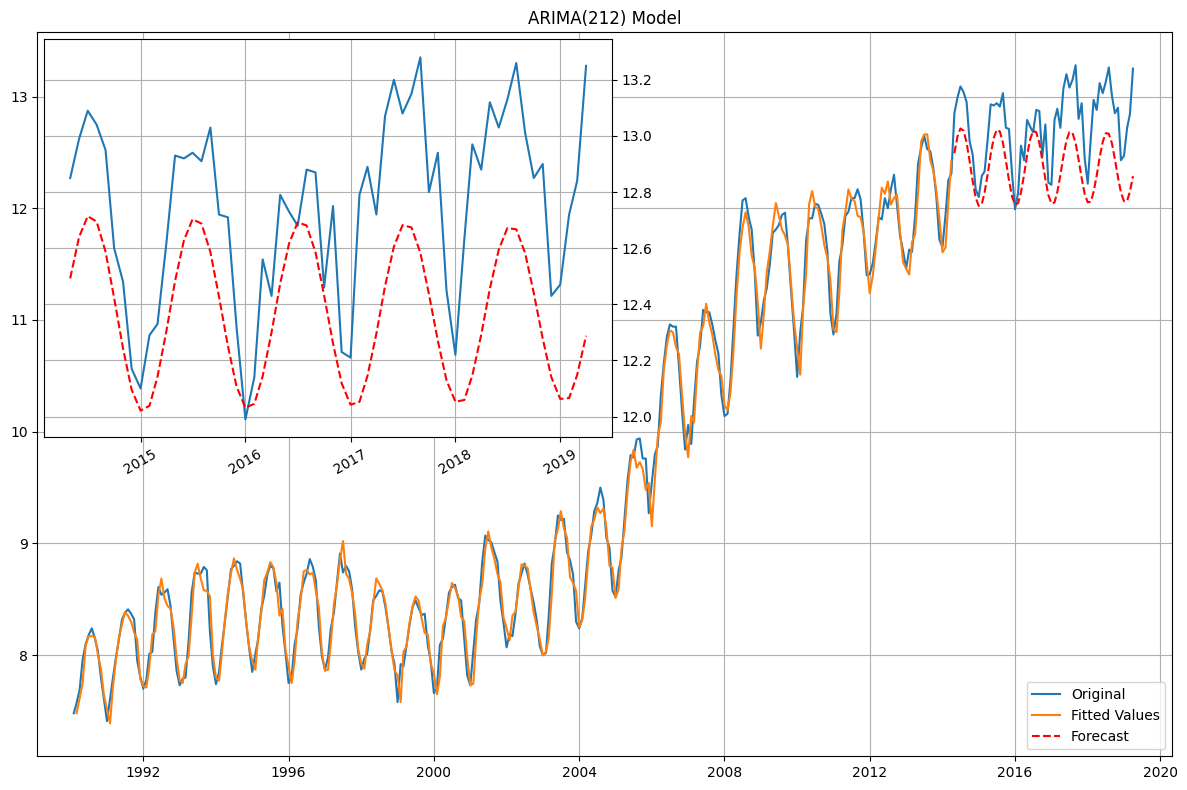

In [130]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], forecast_arima1),
    root_mean_squared_error(ytest[:forecast_length], forecast_arima1)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
ax.plot(model_arima_fit1.fittedvalues[1:], label='Fitted Values')
ax.plot(forecast_arima1, c='r', ls='--', label='Forecast')
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="50%", height="55%", loc=2)
inset.plot(ytest[:forecast_length])
inset.plot(forecast_arima1, c='r', ls='--')
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    datetime.date(train.index[0].year-1,train.index[0].month,1),
    datetime.date(test.index[forecast_length].year+1,test.index[forecast_length].month, 1)
)
ax.set_title('ARIMA(212) Model')
plt.tight_layout()
plt.show()

### __SARIMAX Model__

SARIMAX can take exogenous variables as well as y.

In [87]:
# Find best seasonal order using auto_arima
from pmdarima import auto_arima

In [121]:
model_sarima_auto = auto_arima(y=ytrain, #endogenous data,
                               X=extrain, #exogenous data
                               seasonal=True, #SARIMA
                               m=12, # monthly frequency
                               )

In [123]:
# Print best model order
print("Best (p, d, q):", model_sarima_auto.order)
print("Best (P, D, Q, s):", model_sarima_auto.seasonal_order)

Best (p, d, q): (3, 0, 2)
Best (P, D, Q, s): (2, 0, 2, 12)


In [124]:
model_sarima_auto1 = SARIMAX(endog=ytrain,
                             exog=extrain,
                             order=model_sarima_auto.order,
                             seasonal_order=model_sarima_auto.seasonal_order,
                             )

model_sarima_auto1_fit = model_sarima_auto1.fit(disp=False)
print(model_sarima_auto1_fit.summary())

pred_sarima_auto1 = model_sarima_auto1_fit.forecast(steps=forecast_length, exog=extest[:forecast_length])

                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  291
Model:             SARIMAX(3, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 183.702
Date:                            Sun, 16 Mar 2025   AIC                           -343.405
Time:                                    14:58:43   BIC                           -299.325
Sample:                                02-01-1990   HQIC                          -325.746
                                     - 04-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Population     0.0184      0.060      0.307      0.759      -0.099       0.136
GDP            0.0003      0.001   

MAE: 0.173
RMSE: 0.204


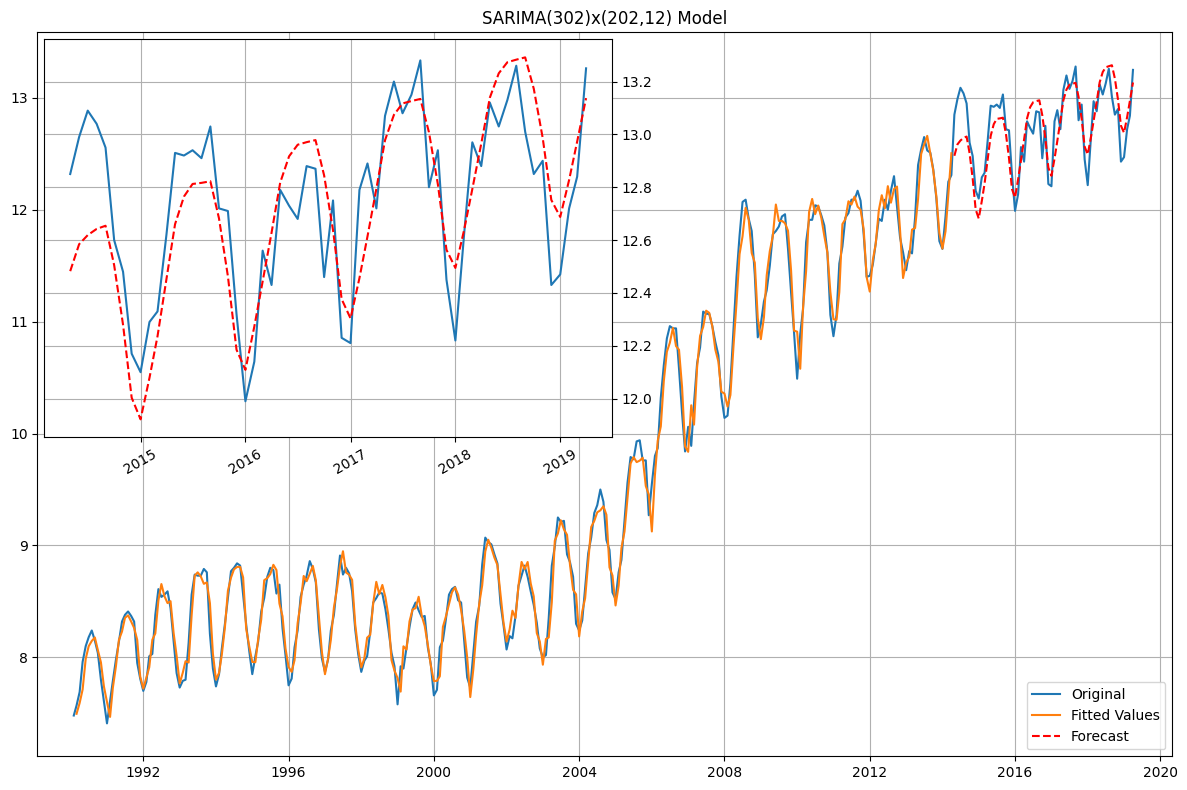

In [125]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_sarima_auto1),
    root_mean_squared_error(ytest[:forecast_length], pred_sarima_auto1)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
ax.plot(model_sarima_auto1_fit.fittedvalues[1:], label='Fitted Values')
ax.plot(pred_sarima_auto1, c='r', ls='--', label='Forecast')
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="50%", height="55%", loc=2)
inset.plot(ytest[:forecast_length])
inset.plot(pred_sarima_auto1, c='r', ls='--')
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    datetime.date(train.index[0].year-1,train.index[0].month,1),
    datetime.date(test.index[forecast_length].year+1,test.index[forecast_length].month, 1)
)
ax.set_title('SARIMA(302)x(202,12) Model')
plt.tight_layout()
plt.show()

In [126]:
# Sarima model with price and exogenous vars using 212 and 212,12 orders
model_sarima1 = SARIMAX(ytrain, exog=extrain, order=(2,1,2), seasonal_order=(2,1,2,12))
model_sarima_fit1 = model_sarima1.fit(disp=False)
print(model_sarima_fit1.summary())

pred_sarima1 = model_sarima_fit1.forecast(
    steps=forecast_length, exog=extest[:forecast_length]
)

                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  291
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                 189.763
Date:                            Sun, 16 Mar 2025   AIC                           -357.525
Time:                                    14:59:22   BIC                           -317.621
Sample:                                02-01-1990   HQIC                          -341.516
                                     - 04-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Population    -0.0012      0.763     -0.002      0.999      -1.496       1.493
GDP           -0.0044      0.006   

MAE: 0.187
RMSE: 0.230


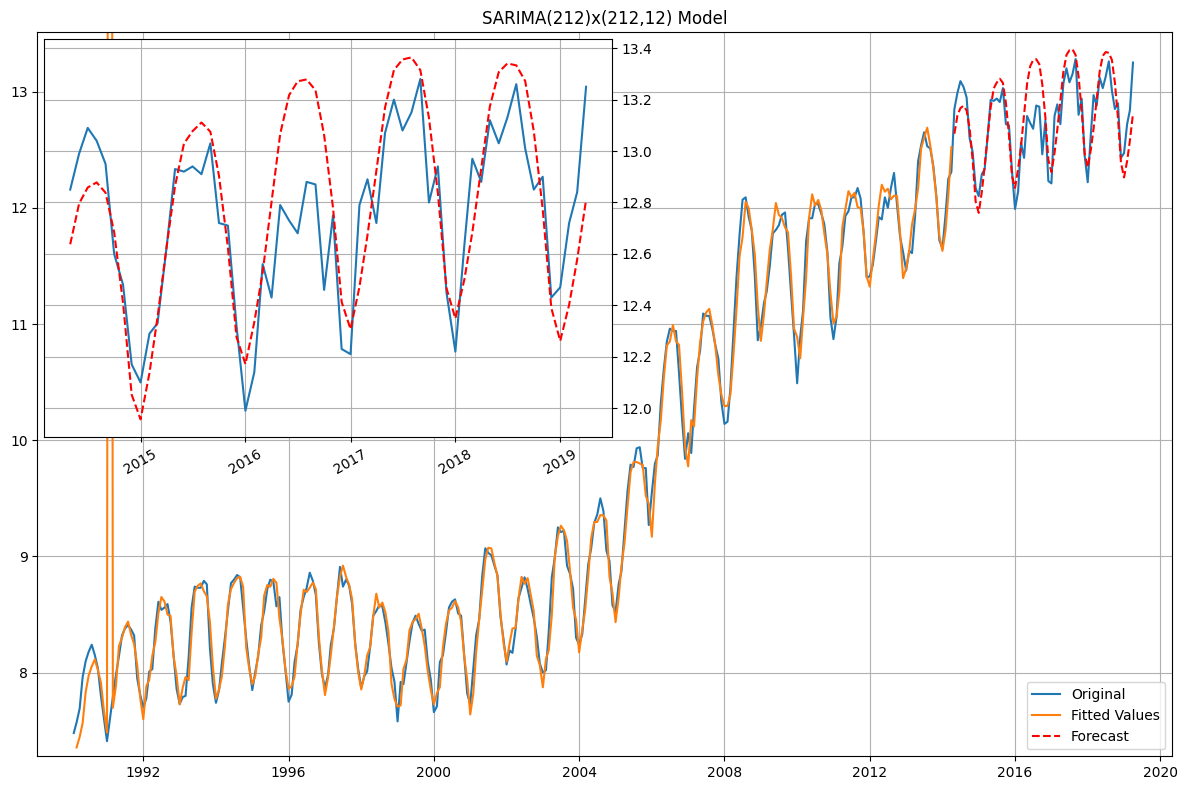

In [127]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_sarima1),
    root_mean_squared_error(ytest[:forecast_length], pred_sarima1)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
ax.plot(model_sarima_fit1.fittedvalues[1:], label='Fitted Values')
ax.plot(pred_sarima1, c='r', ls='--', label='Forecast')
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="50%", height="55%", loc=2)
inset.plot(ytest[:forecast_length])
inset.plot(pred_sarima1, c='r', ls='--')
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    datetime.date(train.index[0].year-1,train.index[0].month,1),
    datetime.date(test.index[forecast_length].year+1,test.index[forecast_length].month, 1)
)
ax.set_ylim(ytrain[0]-0.2, ytest[forecast_length]+0.2)
ax.set_title('SARIMA(212)x(212,12) Model')
plt.tight_layout()
plt.show()

### Exog + Endog Vars Together

In [ ]:
model_sarima_auto_merge = auto_arima(y=ytrain, #endogenous data,
                               X=pd.merge(xtrain, extrain, left_index=True, right_index=True), #exogenous data
                               seasonal=True, #SARIMA
                               m=12, # monthly frequency
                               )

# Print best model order
print("Best (p, d, q):", model_sarima_auto_merge.order)
print("Best (P, D, Q, s):", model_sarima_auto_merge.seasonal_order)

Best (p, d, q): (2, 0, 2)
Best (P, D, Q, s): (1, 0, 1, 12)


In [ ]:
model_sarima_auto2 = SARIMAX(endog=ytrain,
                             exog=pd.merge(xtrain, extrain, left_index=True, right_index=True),
                             order=model_sarima_auto_merge.order,
                             seasonal_order=model_sarima_auto_merge.seasonal_order,
                             )

model_sarima_auto2_fit = model_sarima_auto2.fit(disp=False)
print(model_sarima_auto2_fit.summary())

pred_sarima_auto2 = model_sarima_auto2_fit.forecast(steps=forecast_length, exog=pd.merge(xtest, extest, left_index=True, right_index=True)[:forecast_length])

                                      SARIMAX Results                                       
Dep. Variable:                                Price   No. Observations:                  291
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 115.537
Date:                              Sun, 16 Mar 2025   AIC                           -205.074
Time:                                      18:25:33   BIC                           -157.321
Sample:                                  02-01-1990   HQIC                          -185.944
                                       - 04-01-2014                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Renewable       1.569e-05      0.001      0.026      0.979      -0.001       0.001
Petrole

MAE: 0.380
RMSE: 0.441


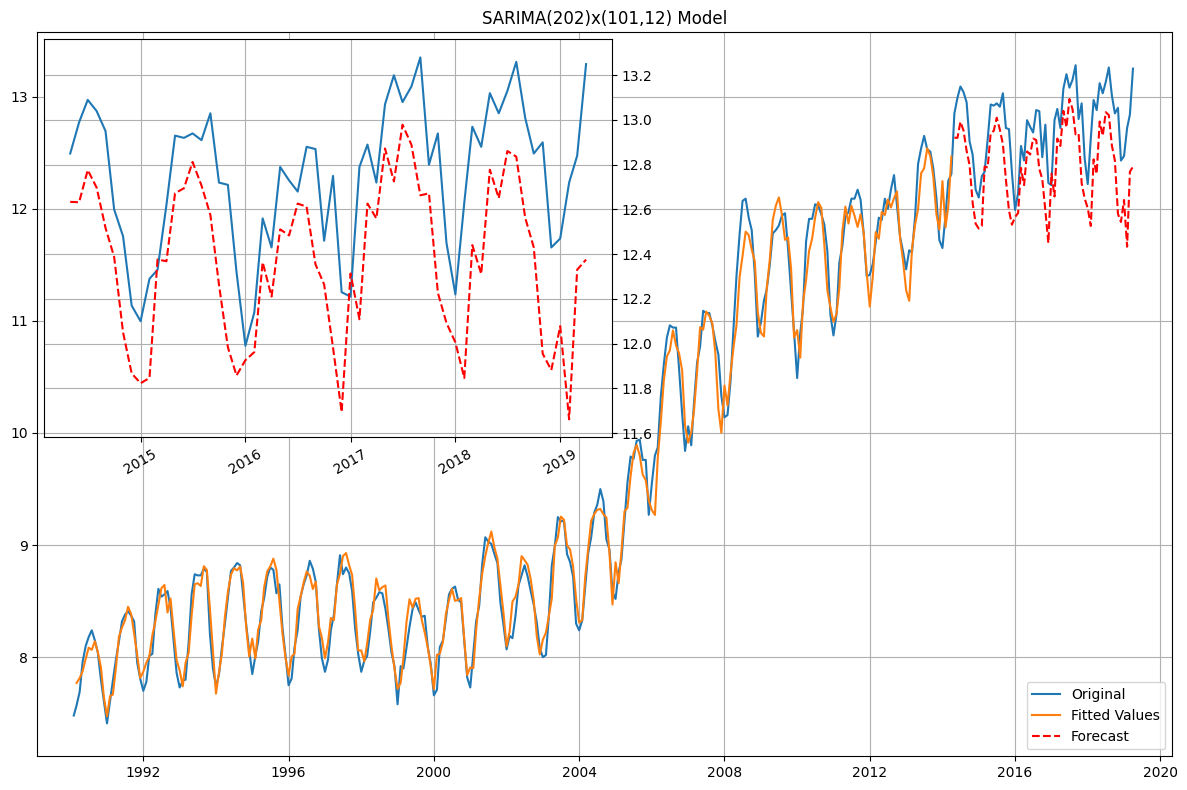

In [140]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_sarima_auto2),
    root_mean_squared_error(ytest[:forecast_length], pred_sarima_auto2)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
ax.plot(model_sarima_auto2_fit.fittedvalues[1:], label='Fitted Values')
ax.plot(pred_sarima_auto2, c='r', ls='--', label='Forecast')
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="50%", height="55%", loc=2)
inset.plot(ytest[:forecast_length])
inset.plot(pred_sarima_auto2, c='r', ls='--')
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    datetime.date(train.index[0].year-1,train.index[0].month,1),
    datetime.date(test.index[forecast_length].year+1,test.index[forecast_length].month, 1)
)
ax.set_title('SARIMA(202)x(101,12) Model')
plt.tight_layout()
plt.show()

### __VAR Model__

In [147]:
temp_mod = VAR(train)
lag_order = temp_mod.select_order(maxlags=15)
print(lag_order.summary())

best_lag = lag_order.aic
print('Optimal lag order: ', best_lag)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        22.41       22.48   5.417e+09       22.44
1        12.06       12.45   1.721e+05       12.21
2        9.632       10.35   1.524e+04       9.921
3        9.103      10.15*       8984.       9.524
4        8.918       10.30       7475.       9.471
5        8.818       10.52       6774.       9.502
6        8.780       10.81       6536.       9.596
7        8.442       10.80       4671.       9.389
8        8.414       11.10       4558.       9.493
9        8.297       11.31       4077.       9.508
10       8.266       11.61       3972.       9.608
11       8.049       11.72       3223.       9.523
12       7.550       11.55       1973.       9.156
13      7.396*       11.73      1709.*      9.133*
14       7.431       12.09       1790.       9.300
15       7.461       12.45       1871.       9.461
-------------------------------

In [148]:
model_var = VAR(endog=train, exog=extrain, dates=train.index)
model_var_fit = model_var.fit(best_lag)
print(model_var_fit.summary())

forecast_var = model_var_fit.forecast(y=train.values[-best_lag:], steps=forecast_length, exog_future=extest[:forecast_length])

forecast_var = pd.DataFrame(forecast_var)
forecast_var.columns = train.columns
forecast_var.index = test.index[:len(forecast_var)]

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 16, Mar, 2025
Time:                     18:32:21
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    11.7050
Nobs:                     278.000    HQIC:                   9.04827
Log likelihood:          -2642.62    FPE:                    1508.59
AIC:                      7.26832    Det(Omega_mle):         505.144
--------------------------------------------------------------------
Results for equation Price
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     23.965153        25.427766            0.942           0.346
Population                -0.129482         0.145350           -0.891           0.373
GDP                        0.000766     

This model sees much less correlation between Price and the other features, perhaps due to differencing.

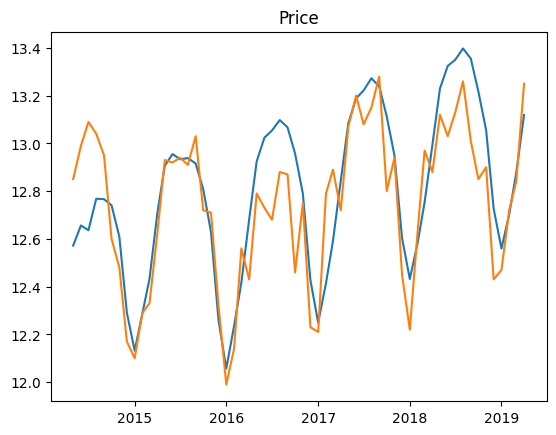

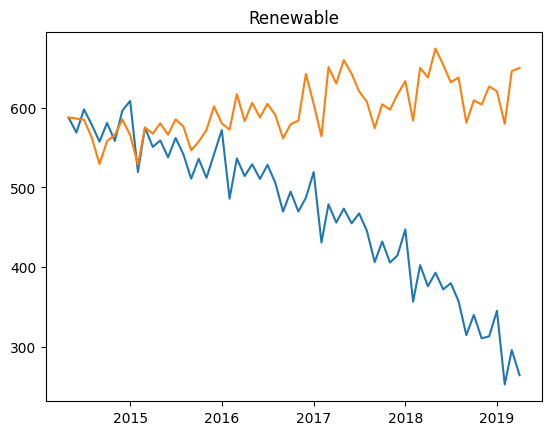

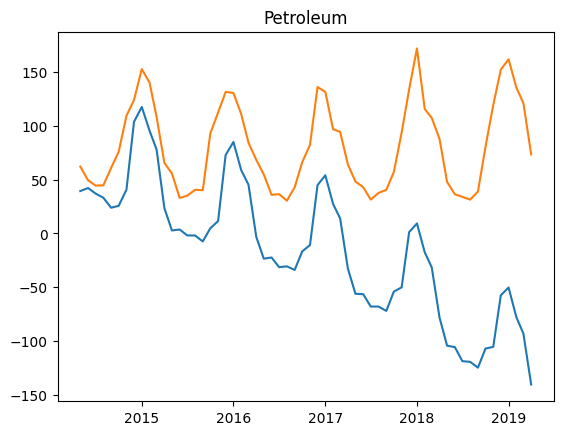

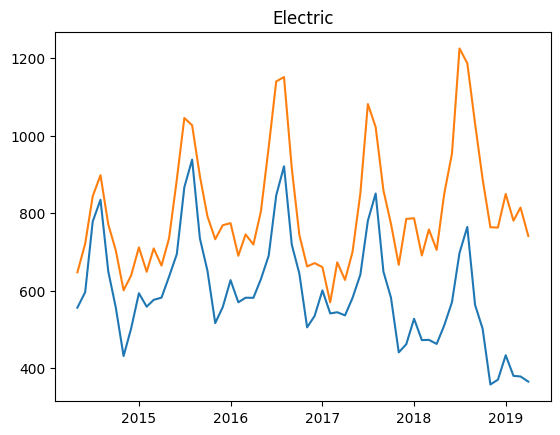

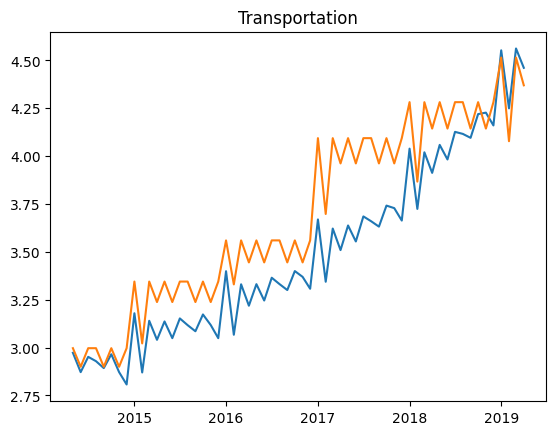

In [149]:
for col in forecast_var:
    plt.figure()
    plt.title(col)
    plt.plot(forecast_var[col], label='Prediction')
    plt.plot(test[col][:len(forecast_var)])
    plt.show()

MAE: 0.159
RMSE: 0.200


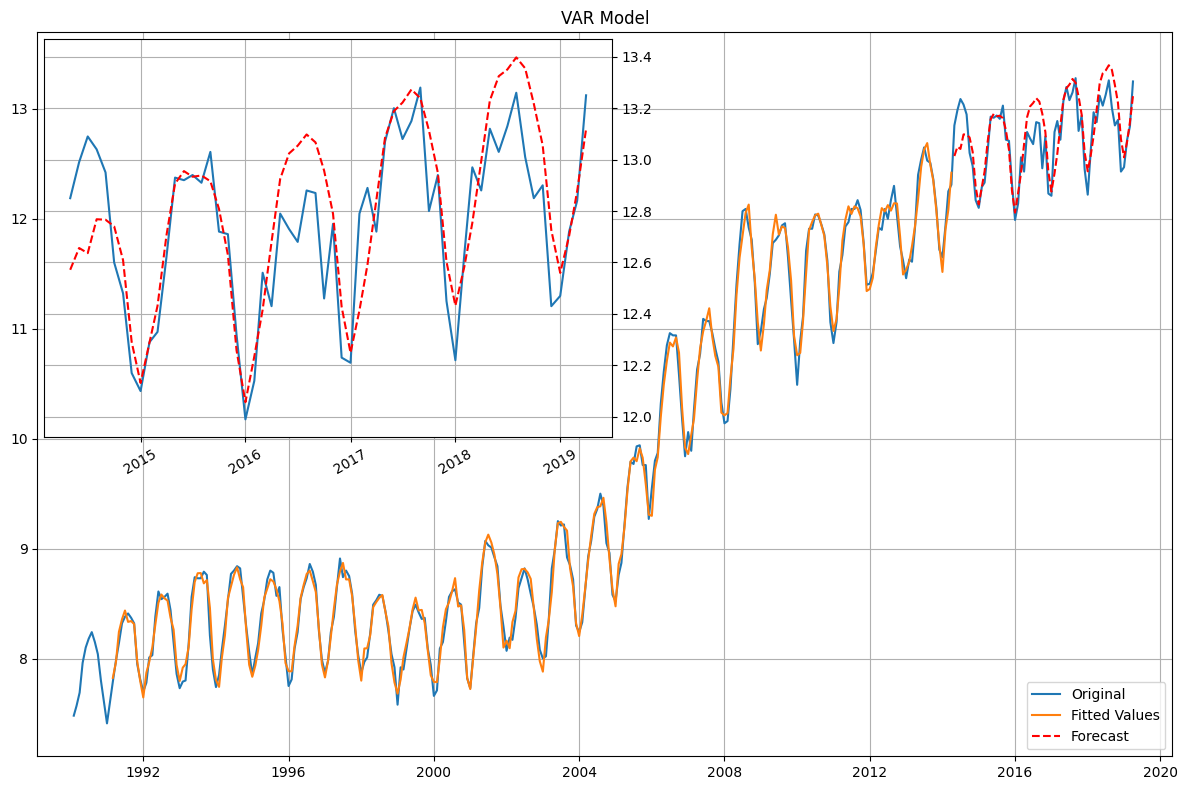

In [151]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], forecast_var.Price),
    root_mean_squared_error(ytest[:forecast_length], forecast_var.Price)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
ax.plot(model_var_fit.fittedvalues[:].Price, label='Fitted Values')
ax.plot(forecast_var.Price, c='r', ls='--', label='Forecast')
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="50%", height="55%", loc=2)
inset.plot(ytest[:forecast_length])
inset.plot(forecast_var.Price, c='r', ls='--')
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    datetime.date(train.index[0].year-1,train.index[0].month,1),
    datetime.date(test.index[forecast_length].year+1,test.index[forecast_length].month, 1)
)
ax.set_title('VAR Model')
plt.tight_layout()
plt.show()

### __FB Prophet__

13:21:39 - cmdstanpy - INFO - Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 640x480 with 0 Axes>

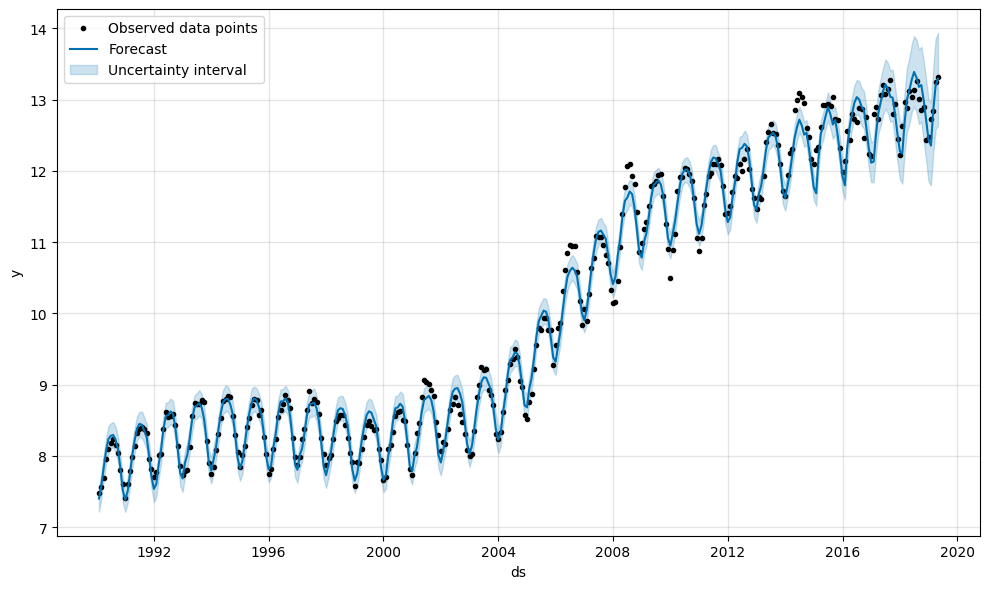

In [32]:
from prophet import Prophet

# New df specifically for FB Prophet
dfproph = pd.DataFrame()
dfproph['ds'] = train.index
dfproph['y'] = train.Price.values

m = Prophet()
m.fit(dfproph)

future = m.make_future_dataframe(periods=forecast_length+1, freq='M')
pred_fb = m.predict(future)

plt.figure()
m.plot(fcst=pred_fb, include_legend=True)
plt.scatter(ytest[:forecast_length+1].index, ytest[:forecast_length+1].values, c='k', marker='.')
plt.show()

In [33]:
pred_fb

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1990-02-01,7.787909,7.217670,7.573691,7.787909,7.787909,-0.386942,-0.386942,-0.386942,-0.386942,-0.386942,-0.386942,0.0,0.0,0.0,7.400968
1,1990-03-01,7.799908,7.389121,7.739001,7.799908,7.799908,-0.233793,-0.233793,-0.233793,-0.233793,-0.233793,-0.233793,0.0,0.0,0.0,7.566115
2,1990-04-01,7.813193,7.645518,8.002676,7.813193,7.813193,0.011160,0.011160,0.011160,0.011160,0.011160,0.011160,0.0,0.0,0.0,7.824353
3,1990-05-01,7.826049,7.879448,8.248614,7.826049,7.826049,0.235261,0.235261,0.235261,0.235261,0.235261,0.235261,0.0,0.0,0.0,8.061310
4,1990-06-01,7.839333,8.049308,8.410713,7.839333,7.839333,0.395929,0.395929,0.395929,0.395929,0.395929,0.395929,0.0,0.0,0.0,8.235262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,2018-12-31,13.002105,11.847070,13.009244,12.452607,13.558234,-0.565904,-0.565904,-0.565904,-0.565904,-0.565904,-0.565904,0.0,0.0,0.0,12.436201
348,2019-01-31,13.016313,11.796217,12.949070,12.447338,13.594412,-0.662592,-0.662592,-0.662592,-0.662592,-0.662592,-0.662592,0.0,0.0,0.0,12.353721
349,2019-02-28,13.029147,12.232105,13.436895,12.441695,13.630675,-0.190894,-0.190894,-0.190894,-0.190894,-0.190894,-0.190894,0.0,0.0,0.0,12.838253
350,2019-03-31,13.043355,12.582522,13.850073,12.436666,13.655974,0.151999,0.151999,0.151999,0.151999,0.151999,0.151999,0.0,0.0,0.0,13.195354


In [34]:
pred_fb.set_index('ds', inplace=True)

MAE: 0.202
RMSE: 0.248


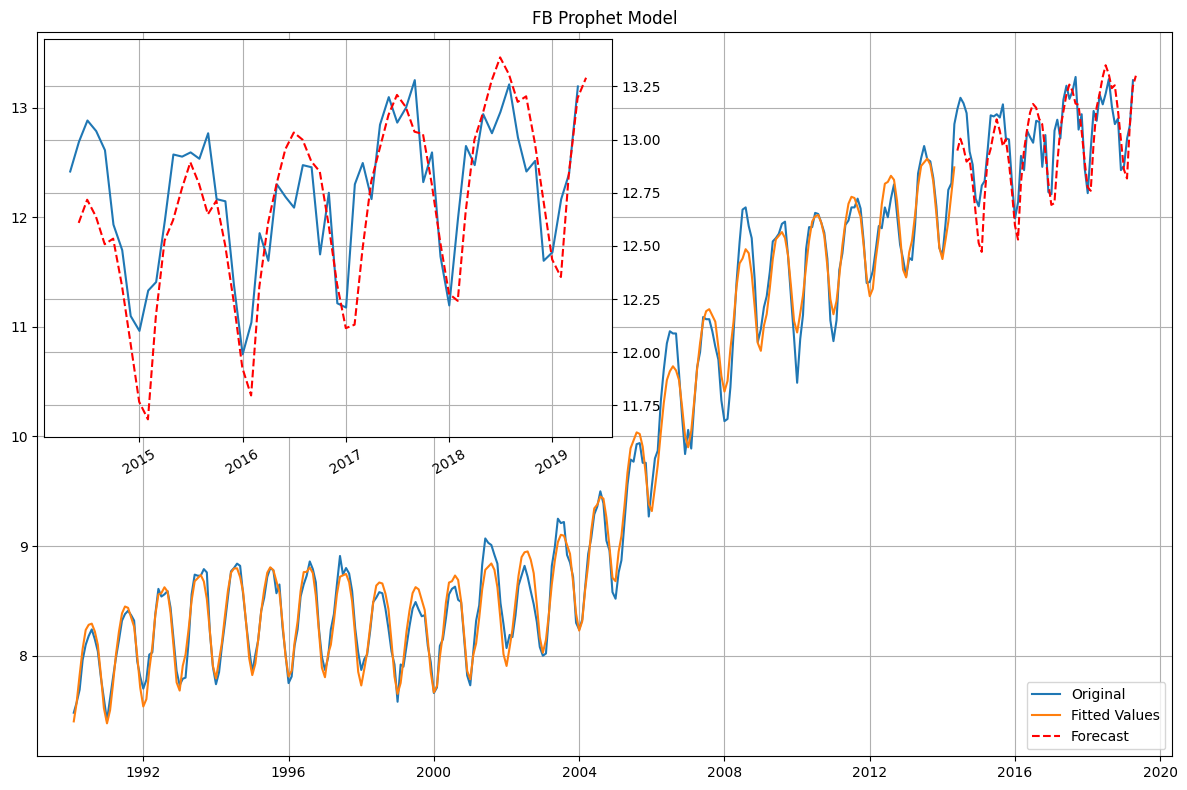

In [173]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_fb.yhat[splitdate:]),
    root_mean_squared_error(ytest[:forecast_length], pred_fb.yhat[splitdate:])
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
ax.plot(pred_fb.yhat[:splitdate], label='Fitted Values')
ax.plot(pred_fb.yhat[splitdate:], c='r', ls='--', label='Forecast')
ax.grid(True)
ax.legend(loc='lower right')
# ins = ax.inset_axes([0, 0.5, 0.2,0.2])
inset = inset_axes(ax, width="50%", height="55%", loc=2)
inset.plot(ytest[:forecast_length])
inset.plot(pred_fb.yhat[splitdate:], c='r', ls='--')
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    datetime.date(train.index[0].year-1,train.index[0].month,1),
    datetime.date(test.index[forecast_length].year+1,test.index[forecast_length].month, 1)
)
ax.set_title('FB Prophet Model')
plt.tight_layout()
plt.show()

FB Prophet model does very well with data, achieving MSE of 0.08.

### __Exponential Smoothing__

In [36]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [37]:
# Define the Holt-Winters model
model_es = ExponentialSmoothing(ytrain, 
                             trend="add",  # Linear trend
                             seasonal="add",  # Seasonal component
                             seasonal_periods=12)  # 12 months for yearly seasonality

# Fit the model
model_es_fit = model_es.fit()

# Forecast the next test period
forecast_es = model_es_fit.forecast(steps=forecast_length)

In [52]:
print(model_es_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  291
Model:             ExponentialSmoothing   SSE                              3.752
Optimized:                         True   AIC                          -1234.151
Trend:                         Additive   BIC                          -1175.378
Seasonal:                      Additive   AICC                         -1231.636
Seasonal Periods:                    12   Date:                 Sun, 16 Mar 2025
Box-Cox:                          False   Time:                         13:42:18
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7837446                alpha                 True
smoothing_trend          

MAE: 0.206
RMSE: 0.249


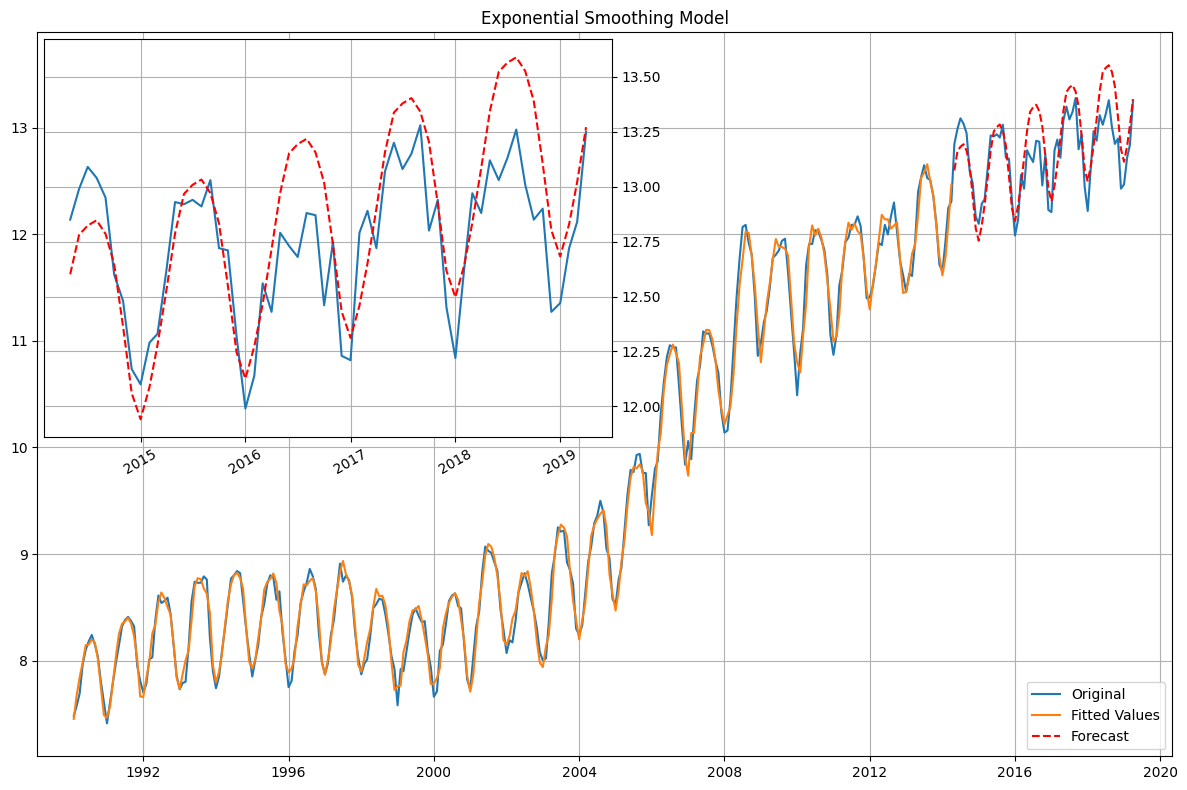

In [174]:
print('MAE: {:.3f}\nRMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], forecast_es),
    root_mean_squared_error(ytest[:forecast_length], forecast_es)
))

# Plot
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
ax.plot(model_es_fit.fittedvalues, label='Fitted Values')
ax.plot(forecast_es, c='r', ls='--', label='Forecast')
ax.grid(True)
ax.legend(loc='lower right')
inset = inset_axes(ax, width="50%", height="55%", loc=2)
inset.plot(ytest[:forecast_length])
inset.plot(forecast_es, c='r', ls='--')
inset.grid(visible=True)
inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.set_xticklabels(labels=inset.get_xticklabels(), rotation=30)
ax.set_xlim(
    datetime.date(train.index[0].year-1,train.index[0].month,1),
    datetime.date(test.index[forecast_length].year+1,test.index[forecast_length].month, 1)
)
ax.set_title('Exponential Smoothing Model')
plt.tight_layout()
plt.show()

Exponential Smoothing model works great.

In [39]:
# One step ahead cross validation
def one_step_ahead_cv(model_class, model_params, y, train_size=split):
    """
    Perform rolling-origin one-step-ahead cross-validation.
    
    Parameters:
        model_class: The forecasting model class (e.g., ARIMA, ExponentialSmoothing).
        model_params: Dictionary of parameters for the model.
        y: Time series data.
        train_size: Proportion of data to use for initial training.

    Returns:
        y_test: Actual test values.
        predictions: Model forecasts.
    """
    train_len = int(len(y) * train_size)
    train, test = y[:train_len], y[train_len:]
    
    history = list(train)  # Start with initial training set
    predictions = []
    
    for t in range(len(test)):
        # Fit model on the current history
        model = model_class(history, **model_params).fit()
        
        # Predict the next step
        forecast = model.forecast(steps=1)[0]
        predictions.append(forecast)
        
        # Add true value to training set (walk-forward validation)
        history.append(test.iloc[t])

    return test, predictions

In [40]:
datetime.date(int(splitdate.year+forecast_length/12), splitdate.month,1)

datetime.date(2019, 5, 1)

In [41]:
# Define ARIMA model parameters
arima_params = {"order": (2,1,2)}

# Run one-step-ahead validation
y_test, arima_preds = one_step_ahead_cv(ARIMA, arima_params, df.Price)

# Compute performance
mae = mean_absolute_error(y_test, arima_preds)
rmse = np.sqrt(mean_squared_error(y_test, arima_preds))
print(f"ARIMA MAE: {mae:.4f}, RMSE: {rmse:.4f}")

ARIMA MAE: 0.1992, RMSE: 0.2539


In [42]:
# Define Exponential Smoothing parameters
hw_params = {"trend": "add", "seasonal": "add", "seasonal_periods": 12}

# Run cross-validation
y_test, hw_preds = one_step_ahead_cv(ExponentialSmoothing, hw_params, df.Price)
# [:datetime.date(int(splitdate.year+forecast_length/12), splitdate.month,1)]

# Evaluate
mae = mean_absolute_error(y_test, hw_preds)
rmse = np.sqrt(mean_squared_error(y_test, hw_preds))
print(f"Holt-Winters MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Holt-Winters MAE: 0.1738, RMSE: 0.2216


In [43]:

def one_step_ahead_cv_var(df, train_size=split, lags=2):
    train_len = int(len(df) * train_size)
    train, test = df.iloc[:train_len], df.iloc[train_len:]

    history = train.copy()
    predictions = []

    for t in range(len(test)):
        model = VAR(history)
        model_fitted = model.fit(lags)
        forecast = model_fitted.forecast(history.values[-lags:], steps=1)
        predictions.append(forecast[0])

        # Add true values to history
        history = pd.concat([history, test.iloc[[t]]])

    return test, np.array(predictions)

# Apply to dataset
y_test, var_preds = one_step_ahead_cv_var(df[["Price", "Electric"]], lags=2)

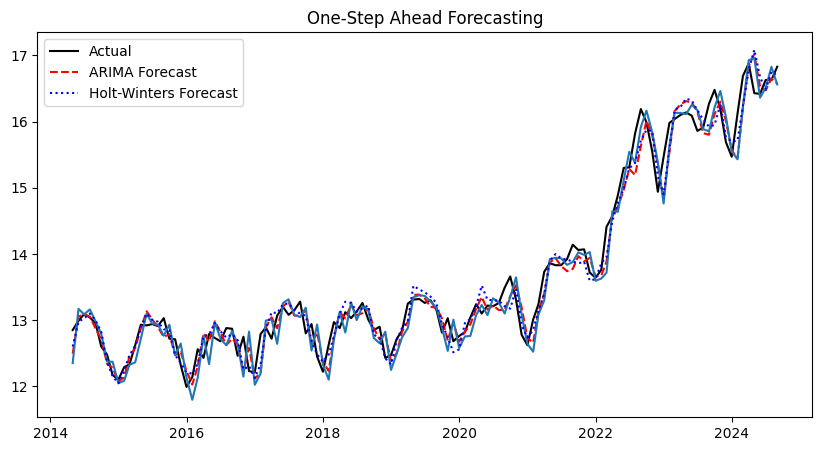

In [44]:
plt.figure(figsize=(10,5))
plt.plot(y_test.Price, label="Actual", color="black")
plt.plot(y_test.index, arima_preds, label="ARIMA Forecast", linestyle="dashed", color="red")
plt.plot(y_test.index, var_preds[:,0])
plt.plot(y_test.index, hw_preds, label="Holt-Winters Forecast", linestyle="dotted", color="blue")
plt.legend()
plt.title("One-Step Ahead Forecasting")
plt.show()

### __Summary__

#### Model Statistics
(For split size 0.7)

1: ARIMA(212)\
&emsp;This model did not have great prediction, capturing some seasonality but not trend. MAE: 0.382, RMSE: 0.438.

2: SARIMAX(302)x(202,12) exogenous = exogenous\
&emsp;This model had great prediction and is the second best performing model, MAE: 0.173, RMSE: 0.204.

3: SARIMAX(212)x(212,12) exogenous = exogenous\
&emsp;This model performed well, similar to above but MAE and RMSE slightly higher.

4: SARIMAX(202)x(101,12) exogenous = merge\
&emsp;This model performed okay, capturing seasonality but not quite trend. MAE: 0.380, MSE: 0.441.

5: VAR\
&emsp;This model performsvery well, only beating model 2 by 0.004 RMSE. MAE: 0.159, RMSE: 0.200.

6: Facebook Prophet\
&emsp;This model performs nicely, MAE: 0.202, MSE: 0.248.

7: Exponential Smoothing\
&emsp;This model does well, MAE: 0.2, MSE: 0.249.